# Object Detection : Phát hiện các đối tượng trong hình ảnh


TensorFlow cũng cung cấp pre-trained model, được trained trên bộ MS COCO dataset, Kitti, hoặc tập dữ liệu Open Images (khoảng 9tr data hình ảnh đa dạng).

## Setup


In [ ]:
#  TF-Hub module.
# import thư viện tensorflow
import tensorflow as tf
import tensorflow_hub as hub

# Download hình ảnh
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# Xử lý hình ảnh - vẽ các hộp giới hạn (bounding box) trong tấm ảnh
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Đo thời gian
import time

## Example

### Chức năng trợ giúp để tải xuống hình ảnh và để trực quan hóa

In [85]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  # tạo thư mục tạm thời lưu trữ ảnh sau khi download
  _, filename = tempfile.mkstemp(suffix=".jpg")
  # đọc url
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  # đọc ảnh
  pil_image = Image.open(image_data)
  # change width and height
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  # lưu ảnh vào thư mục tạm
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)

  display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  draw = ImageDraw.Draw(image)

  # width, height của ảnh
  im_width, im_height = image.size
  # tính kích thước của box

  # ymin, xmin, ymax, xmax là tỉ lệ độ dài box trong 1 tấm ảnh
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  # vẽ các line tạo thành 1 box: 4 điểm bounding box - nối thành 1 hình chữ nhật
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
            width=thickness,
            fill=color)

  # Nếu tổng chiều dài của các chuỗi classes được thêm vào bounding box mà vượt quá chiều dài bounding box của hình ảnh.
  # 
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list] # Lấy size của string classes
  # print(display_str_heights)
  # Mỗi display_str có top và bottom margin là 0.05*x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  # text_bottom = top

  # Đảo ngược list và in từ bottom đến top.
  for display_str in display_str_list[::-1]:
    # Lấy width, height của chuỗi classes
    text_width, text_height = font.getsize(display_str)

    # Tạo margin cho display box classes
    margin = np.ceil(0.05 * text_height)

    # Vẽ display box cho classes -> draw.rectangle([(x0, y0), (x1, y1)]) 2 điểm xác định giới hạn của display box
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)

    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes = 20, min_score = 0.1):
  # max_boxes: Số lượng bounding box sẽ được hiển thị trên ảnh
  # min_score: accuracy nhỏ nhất sẽ là 0.1
  # Vẽ các bounding box lên ảnh
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/content/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font không tìm thấy, sử dụng front mặc định.")
    font = ImageFont.load_default()
  # boxes.shape[0] = 100 -> shape: số lượng row columns trong array
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      # Tạo các string score
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      # print(display_str)
      color = colors[hash(class_names[i]) % len(colors)] # Lấy màu ngẫu nghiễn hash(classes) % len(colors)
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      # Truyền các value của bouding box -> vẽ các bounding box
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Chọn một model object detection và áp dụng trên hình ảnh đã tải xuống. model pre-trained:
* **FasterRCNN+InceptionResNet V2**: high accuracy, -> "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
* **ssd+mobilenet V2**: small and fast. -> "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  # Decode 1 JPEG-encoded image thành 1 uint8 tensor - ensor là một kiểu dữ liệu dạng mảng.
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  # Conver img thành array number
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  # Đem vào detector được khai báo từ module -> tìm các bounding_box
  result = detector(converted_img)
  end_time = time.time()

  # chuyển kết quả sau khi detection thành set()
  result = {key:value.numpy() for key,value in result.items()}
  # detection_class_entities, detection_class_names, detection_boxes, detection_scores
  # print(result.items())

  print("Tìm thấy %d objects." % len(result["detection_scores"]))
  print("time: ", end_time-start_time)

  image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

## Thực thi model

Load 1 tấm ảnh, lưu vào thư mục tạm.

Image downloaded to /tmp/tmpzo76j4jn.jpg.


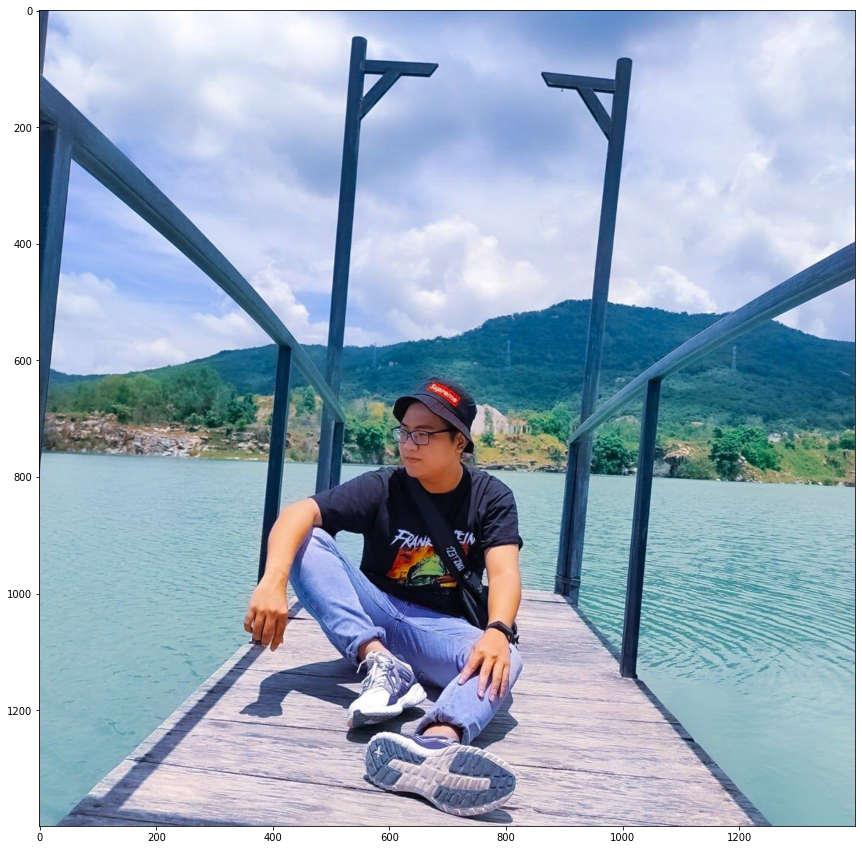

In [47]:
image_url = "https://scontent.fsgn2-6.fna.fbcdn.net/v/t1.6435-9/119790481_1435805893275107_7014240937627143385_n.jpg?_nc_cat=110&ccb=1-3&_nc_sid=174925&_nc_ohc=4jJDLtBDVHQAX_6qUj6&_nc_ht=scontent.fsgn2-6.fna&oh=db094e2848f9758da46187160de03ce3&oe=60AF0AFF"
downloaded_image_path = download_and_resize_image(image_url, 1399, 1399)

Tìm thấy 100 objects.
time:  1.065915584564209


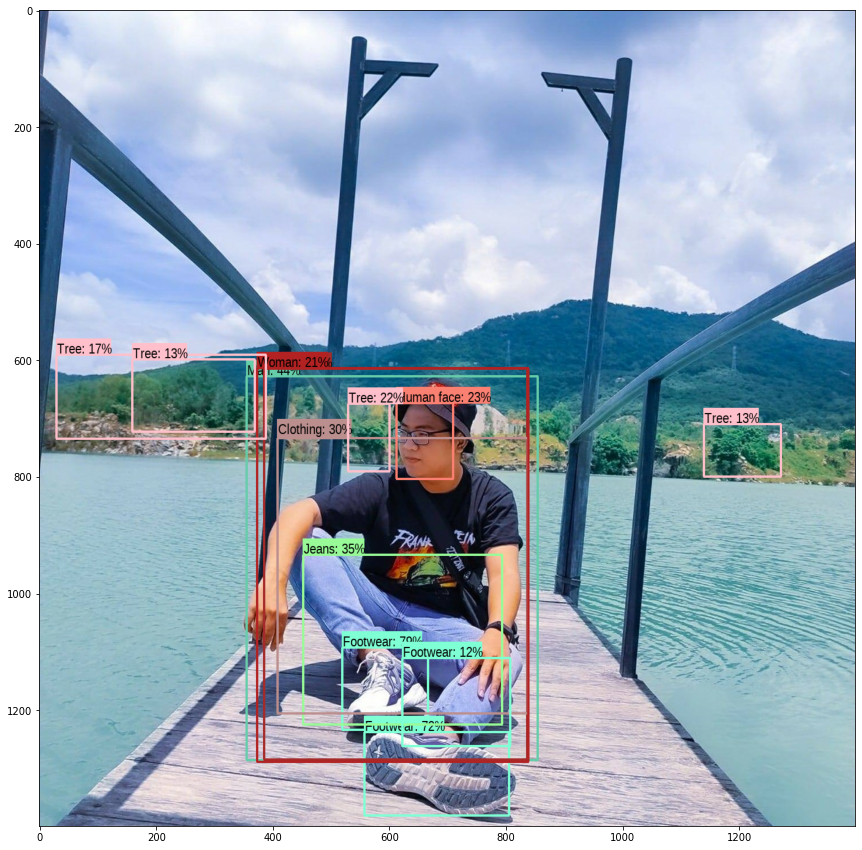

In [86]:
run_detector(detector, downloaded_image_path)